ALNS算法框架

    步骤：
    定义Solution类：解变量，目标函数
    设计 destroy/repair 函数
    注册 destroy/repair 函数
    求初始解
    求解

套裁问题(The cutting-stock problem， CSP)

    CSP求解裁剪出一个item集合需要多少给定beam
    浪费最少化
    一维、二维、三维的CSP之分

例程数据

    第一行：165（个item）
    第二行，材料长度（1000），
    后面165行是165种beam的长度和数量（length, amount）
    最优解：74个beam

该alns包装暴露了两个包，ALNS和State。第一个可以用来运行ALNS算法，第二个可以被子类化以存储解决方案状态-它所需要的只是定义一个objective成员函数。

必须为ALNS算法提供接受标准，以确定每次迭代时是否接受新的解决方案状态。在中alns.criteria，已经为您实现了多个。

HillClimbing：爬山是最简单的接受标准，它仅接受提高目标值的解决方案。
RecordToRecordTravel：仅当改进满足某些更新阈值时，此准则才接受解决方案。
SimulatedAnnealing：当标度概率大于某个随机数时，使用更新温度，此标准接受解。
每个接受条件都继承自AcceptanceCriterion，可以用来编写自己的接受条件。

# CSP问题

仅用非常有限的迭代次数就可以解决一个实例，该实例具有超过165种不同尺寸的180束光束，处于最优性的1.35％以内。

In [1]:
import copy
from functools import partial  
#为函数式编程而设计，用于增强函数功能，partial 相当于一个高阶函数
import matplotlib.pyplot as plt
import numpy as np
import numpy.random as rnd  #随机函数
from alns import ALNS, State
from alns.criteria import HillClimbing

SEED = 6000 #已换参
OPTIMAL_BEAMS = 74

with open('G:/CDO/海上风电场/ALNS/ALNS-master/examples/640.csp') as file:
    data = file.readlines()

NUM_LINES = int(data[0])
BEAM_LENGTH = int(data[1])

# 从可用横梁上切下的材料
ITEMS = [int(length)
         for datum in data[-NUM_LINES:]
         for length, amount in [datum.strip().split()]
         for _ in range(int(amount))]

print("每根可用的横梁都有一定的长度:", BEAM_LENGTH)
print("裁切项目数(订单):", len(ITEMS))


Bad key "text.kerning_factor" on line 4 in
E:\Anaconda3\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


每根可用的横梁都有一定的长度: 1000
裁切项目数(订单): 180


算子(Operators)与(solution state)

    ANLS基本构成:
    算子(destroy/repair)作用于一个解(solution),
    解状态(Solution state)至少有一个objective()计算目标函数

    Solution state
    就是一个描述解(solution)的对象
    两个成员：
    成员: assignments: 已经使用的Beam，每个Beam是一个已经分配的Item的List
    成员: unassigned: 尚未分配的Item的List
    objective: 目标函数：使用的Beam的数量
    plot: soluton plot

In [2]:
class CspState(State):
    def __init__(self, assignments, unassigned=None):
        self.assignments = assignments
        self.unassigned = []

        if unassigned is not None:
            self.unassigned = unassigned

    # 帮助器方法，以确保每个解决方案状态是不可变的。
    def copy(self):
        return CspState(copy.deepcopy(self.assignments),
                        self.unassigned.copy())

    def objective(self):
        return len(self.assignments)

    def plot(self):
        _, ax = plt.subplots(figsize=(15, 7))

        ax.barh(np.arange(len(self.assignments)),
                [sum(assignment) for assignment in self.assignments],
                height=1)

        ax.set_xlim(right=BEAM_LENGTH)
        ax.set_yticks(np.arange(len(self.assignments), step=10))

        ax.margins(x=0, y=0)

        ax.set_xlabel('Usage')
        ax.set_ylabel('Beam (#)')

        plt.draw_if_interactive() 

两个Destroy算子

    Random removal: 随机移除当前分配的光束
    Worst removal: 去除那些目前被切割的最浪费的光束。
    参数：degree_of_destruction: 控制remove的比例

In [3]:
# Helper function: 计算wastage：对一个beam的assignment方案
def wastage(assignment):
    return BEAM_LENGTH - sum(assignment)

degree_of_destruction = 0.25

def beams_to_remove(num_beams):
    return int(num_beams * degree_of_destruction)

def random_removal(state, random_state):
    state = state.copy()
    for _ in range(beams_to_remove(state.objective())):
        idx = random_state.randint(state.objective())         # remove one
        state.unassigned.extend(state.assignments.pop(idx))   # 添加到未赋值的
    return state

def worst_removal(state, random_state):
    state = state.copy()
    # 排序分配浪费，最坏的第一
    state.assignments.sort(key=wastage, reverse=True)
    # 删除最差的赋值
    for _ in range(beams_to_remove(state.objective())):
        state.unassigned.extend(state.assignments.pop(0))
    return state 

两个Repair算子

    greedy_insert: 对每个Item找到合适的Beam就插入，否则就新增加一个Beam.
    minimal_wastage: 插入使得wastage最小的优先.

In [4]:
def greedy_insert(state, random_state):
    random_state.shuffle(state.unassigned) # 洗牌，随机扰动
    while len(state.unassigned) != 0:
        item = state.unassigned.pop(0)
        for assignment in state.assignments:
            if item <= wastage(assignment):
                assignment.append(item)
                break
        else:
            state.assignments.append([item])
    return state

def minimal_wastage(state, random_state):
    def insertion_cost(assignment, item):  # 最小辅助法
        if item <= wastage(assignment):
            return wastage(assignment) - item
        return float("inf")

    while len(state.unassigned) != 0:
        item = state.unassigned.pop(0)
        assignment = min(state.assignments, key=partial(insertion_cost, item=item))
        if item <= wastage(assignment):
            assignment.append(item)
        else:
            state.assignments.append([item])
    return state 

初始解

在ALNS.iterate设置初始解

初始解有目标值: 80


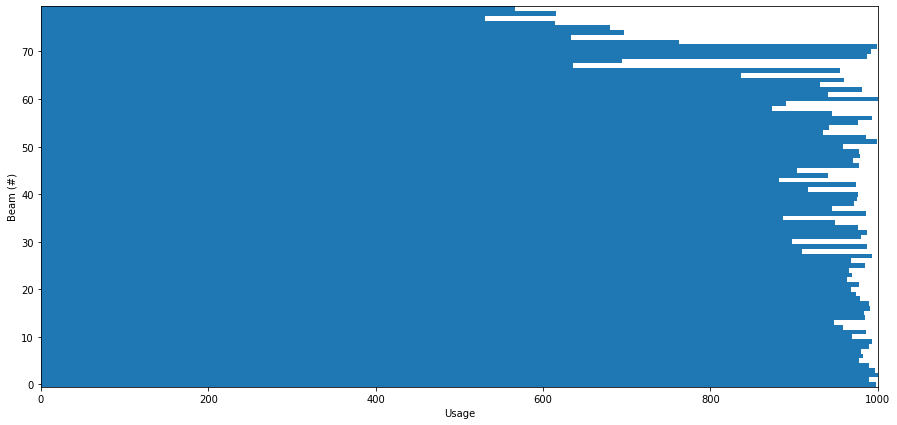

In [5]:
rnd_state = rnd.RandomState(SEED)
state = CspState([], ITEMS.copy())
initial_solution = greedy_insert(state, rnd_state)
print("初始解有目标值:", initial_solution.objective())
initial_solution.plot() 

注册算子

In [6]:
alns = ALNS(rnd_state)
alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(worst_removal)
alns.add_repair_operator(greedy_insert)
alns.add_repair_operator(minimal_wastage)

设置参数

    alns.iterate:
    initial_solution (初始解) :状态:初始解，作为状态对象。
    
    weights (算子权值) : array_like：一个包含四个正元素的列表，表示权重更新当候选解得到一个新的全局最优解(idx0)时，是比当前的解决方案(idx 1)好，解决方案是什么接受(idx2)或不接受(idx3)。
    
    operator_decay: float: 运算符衰减参数，作为单位间隔中的浮点数。
    
    criterion (接受改进解的策略): AcceptanceCriterion: 用于候选状态的接受标准。另请参阅alns.criteria模块的概述。
    
    iterations (迭代次数): int: 迭代的次数。默认10000.
    
    collect_stats (是否统计): bool: 应该在迭代期间收集统计信息吗?默认的事实,但可以在长时间运行时关闭，以减少内存消耗。
    
    
    alns.criteria:验收标准，确定在每次迭代中对新解决方案状态的验收
    
    HillClimbing:爬山是最简单的接受标准，只接受提高客观值的解决方案。

    RecordToRecordTravel:此标准仅在改进满足某些更新阈值时才接受解决方案。

    SimulatedAnnealing:这个准则接受的解决方案时，尺度概率大于某个随机数，使用更新温度。

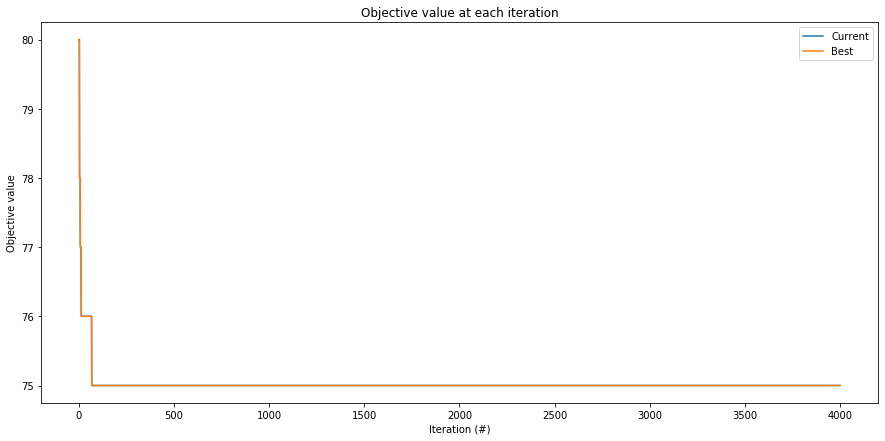

In [7]:
criterion = HillClimbing()

result = alns.iterate(initial_solution, [5, 3, 1, 0.5], 0.75, criterion,
                      iterations=4000, collect_stats=True)

solution = result.best_state
objective = solution.objective()

_, ax = plt.subplots(figsize=(15, 7))
result.plot_objectives(ax=ax)

算子性能

    plot_operator_counts()
    destroy算子性能相当
    minimal_wastage相比greedy_insert要好

In [9]:
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

AttributeError: 'StandardProblem' object has no attribute 'objective'

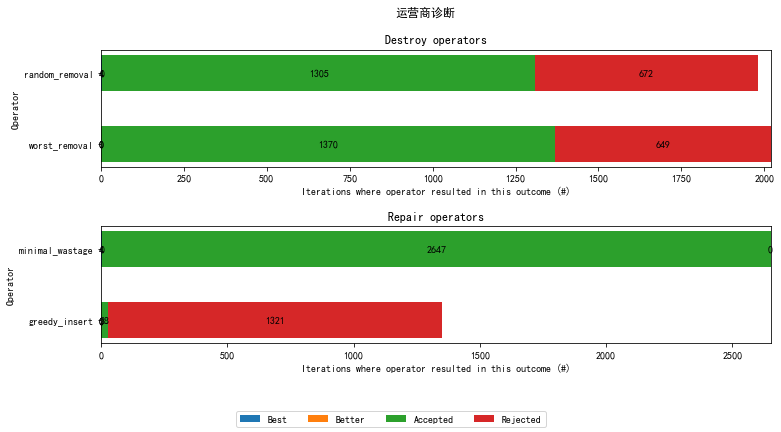

In [14]:
figure = plt.figure("操作数", figsize=(12, 6))
figure.subplots_adjust(bottom=0.2, hspace=.5)
result.plot_operator_counts(figure=figure, title="运营商诊断")

print("启发式解具有客观价值:", solution.objective())

solution.plot()

print("使用梁数为{0}，比最优值{2}多{1}."
      .format(solution.objective(), solution.objective() - OPTIMAL_BEAMS, OPTIMAL_BEAMS))

结果

Each available beam is of length: 1000

Number of ITEMS to be cut (orders): 180

Heuristic solution has objective value: 75

Number of beams used is 75, which is 1 more than the optimal value, which was 74.

# TSP问题

旅行推销员问题
旅行推销员问题(TSP)是运筹学中的一个经典问题。它询问如何构建多个城市之间的最小距离游览，使每个城市游览一次，游览结束于起始城市(即形成一个循环)。这可能是NP-hard问题中最著名的问题。

数据
TSP有大量可用的测试数据集，其大小从100个左右的位置到数十万个位置不等。为了便于说明，我们将使用较小的数据集之一:这里提供的来自XQF131 VLSI实例的数据。它“仅”由131个城市组成，最佳旅游长度为564个。

In [11]:
from alns import ALNS, State
from alns.criteria import HillClimbing
import copy
import itertools
import numpy.random as rnd
import networkx as nx
import tsplib95   
import tsplib95.distances as distances
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
SEED = 9800

In [15]:
data = tsplib95.load('G:/CDO/海上风电场/ALNS/ALNS-master/examples/xqf131.tsp')

# These we will use in our representation of a TSP problem: a list of
# (city, coord)-tuples.
cities = [(city, tuple(coord)) for city, coord in data.node_coords.items()]

solution = tsplib95.load('G:/CDO/海上风电场/ALNS/ALNS-master/examples/xqf131.opt.tour')
optimal = data.trace_tours(solution.tours)[0]

print('总最佳行程为{0}.'.format(optimal))

总最佳行程为564.


In [16]:
def draw_graph(graph, only_nodes=False):
    """
    绘制TSP (tour)图的辅助方法。.
    """
    fig, ax = plt.subplots(figsize=(15, 7))

    func = nx.draw_networkx
 
    if only_nodes:
        func = nx.draw_networkx_nodes

    func(graph, data.node_coords, node_size=25, with_labels=False, ax=ax)

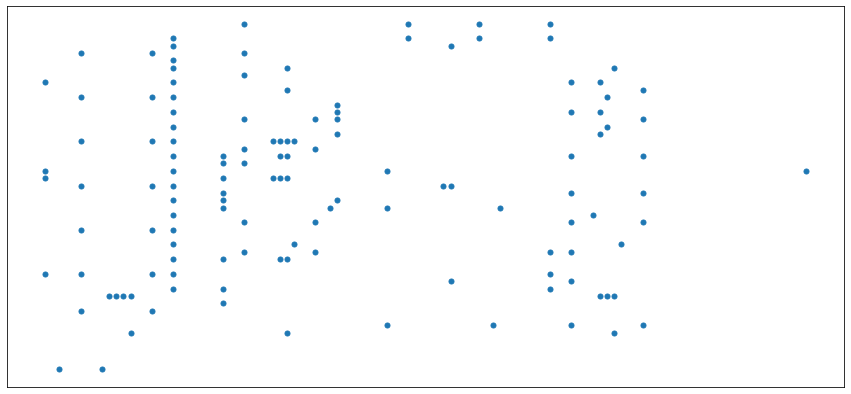

In [22]:
draw_graph(data.get_graph(), True)

操作符和解决方案状态

要使用ALNS元启发式，我们需要有针对已提出的解决方案的破坏和修复操作符，以及一种首先描述此类解决方案的方法。ALNS包公开类状态来描述解决方案，其中包含一个objective()成员，该成员计算此解决方案的目标值。利用它，我们可以计算一个简单的初始解，然后应用ALNS算法。

In [23]:
class TspState(State):
    """
    TSP问题的解决方案类。它有两个数据成员，节点和边。
    节点是节点元组的列表:(id，坐标)。棱数据成员，那么，是从每个节点到它们唯一的传出节点的映射。
    """

    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges

    def copy(self):
        return copy.deepcopy(self)

    def objective(self):
        """
        目标函数就是所有单个边长的和，使用圆角欧几里得范数。
        """
        return sum(distances.euclidean(node[1], self.edges[node][1])
                   for node in self.nodes)
    
    def to_graph(self):
        """
        NetworkX helper method.
        """
        graph = nx.Graph()

        for node, coord in self.nodes:
            graph.add_node(node, pos=coord)

        for node_from, node_to in self.edges.items():
            graph.add_edge(node_from[0], node_to[0])

        return graph 

破坏运营商

破坏操作符分解解决方案的一部分，留下一个不完整的状态。这是每次ALNS元启发式迭代的第一部分;不完全解随后由任意一个修复算子进行修复。我们将考虑三种破坏操作符:最差清除、路径清除和随机清除。我们还将使用一个单独的参数，即破坏程度，来控制每一步对解决方案造成的破坏程度。

In [24]:
degree_of_destruction = 0.25
def edges_to_remove(state):
    return int(len(state.edges) * degree_of_destruction)

In [25]:
def worst_removal(current, random_state):
    """
    迭代地去除“最坏”边，也就是说，就是那些距离最大的边。
    """
    destroyed = current.copy()

    worst_edges = sorted(destroyed.nodes,
                         key=lambda node: distances.euclidean(node[1],
                                                              destroyed.edges[node][1]))

    for idx in range(edges_to_remove(current)):
        del destroyed.edges[worst_edges[-idx -1]]

    return destroyed 

In [27]:
def path_removal(current, random_state):
#删除整个连续子路径，即一系列的连续的边缘。

    destroyed = current.copy()
    
    node_idx = random_state.choice(len(destroyed.nodes))
    node = destroyed.nodes[node_idx]
    
    for _ in range(edges_to_remove(current)):
        node = destroyed.edges.pop(node)

    return destroyed 

In [28]:
def random_removal(current, random_state):

    #随机去除,迭代去除随机边缘。

    destroyed = current.copy()
    
    for idx in random_state.choice(len(destroyed.nodes),
                                   edges_to_remove(current),
                                   replace=False):
        del destroyed.edges[destroyed.nodes[idx]]

    return destroyed

维修经营者

我们实现了一个简单、贪婪的修复策略。它确定当前未访问的一组节点，然后将这些节点链接到循环中，从而形成一个循环。

In [29]:
def would_form_subcycle(from_node, to_node, state):
    """
    确保所建议的解决方案不会导致周期变小,而不是整个节点集。
    注意偏移量:我们不计算所考虑的当前节点，因为它还不能是一个循环。
    """
    for step in range(1, len(state.nodes)):
        if to_node not in state.edges:
            return False

        to_node = state.edges[to_node]
        
        if from_node == to_node and step != len(state.nodes) - 1:
            return True

    return False 

In [30]:
def greedy_repair(current, random_state):
    """
    贪婪地修复一个旅程，缝合没有离开的节点.
    那些没有被访问的。
    """
    visited = set(current.edges.values())
  
    # 这种随机性保证了我们不会在相同的事物之间循环
    # 每次破坏和修复步骤。
    shuffled_idcs = random_state.permutation(len(current.nodes))
    nodes = [current.nodes[idx] for idx in shuffled_idcs]

    while len(current.edges) != len(current.nodes):
        node = next(node for node in nodes 
                    if node not in current.edges)

        # 计算当前未访问的所有节点
        # 也就是这个节点可能访问的那些。这应该不会导致子循环，因为那会违反TSP约束条件。

        unvisited = {other for other in current.nodes
                     if other != node
                     if other not in visited
                     if not would_form_subcycle(node, other, current)}

        # 最值得访问的节点。
        nearest = min(unvisited,
                      key=lambda other: distances.euclidean(node[1], other[1]))

        current.edges[node] = nearest
        visited.add(nearest)

    return current 

In [31]:
random_state = rnd.RandomState(SEED)
state = TspState(cities, {})

initial_solution = greedy_repair(state, random_state)

print("初始解目标为{0}.".format(initial_solution.objective()))

初始解目标为779.


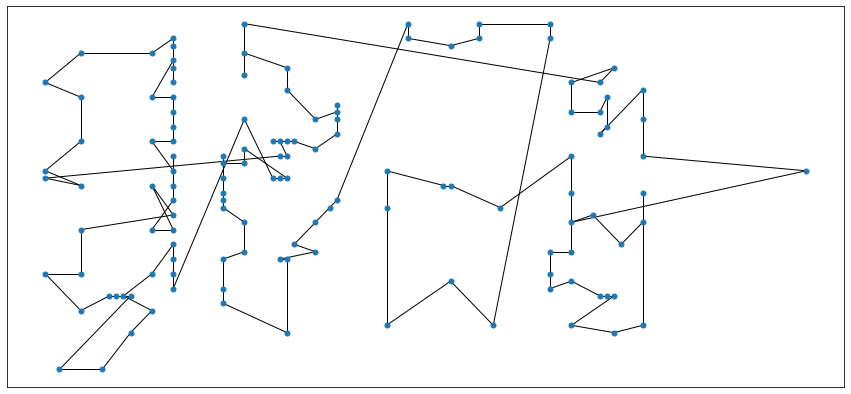

In [32]:
draw_graph(initial_solution.to_graph()) 

启发式解

In [33]:
alns = ALNS(random_state)
alns.add_destroy_operator(random_removal)
alns.add_destroy_operator(path_removal)
alns.add_destroy_operator(worst_removal)
alns.add_repair_operator(greedy_repair) 

In [34]:
# 这也许是最简单的选择标准，我们只接受
# 更好的解决方案。
criterion = HillClimbing()

result = alns.iterate(initial_solution, [3, 2, 1, 0.5], 0.8, criterion,
                      iterations=4000, collect_stats=True)

solution = result.best_state

objective = solution.objective() 

最佳启发式目标是624.
This is 10.6% worse than the optimal solution, which is 564.


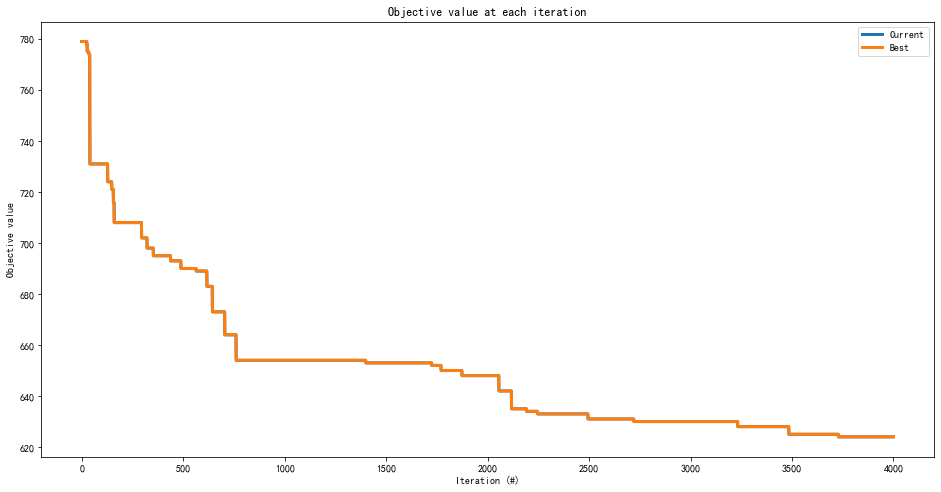

In [35]:
print('最佳启发式目标是{0}.'.format(objective))
print('This is {0:.1f}% worse than the optimal solution, which is {1}.'
      .format(100 * (objective - optimal) / optimal, optimal))

_, ax = plt.subplots(figsize=(16, 8))
result.plot_objectives(ax=ax, lw=3)

在得到合理的解决方案之后，我们现在想研究每个操作符的性能。这可以通过结果对象上的plot_operator_counts()方法来完成，如下所示。 

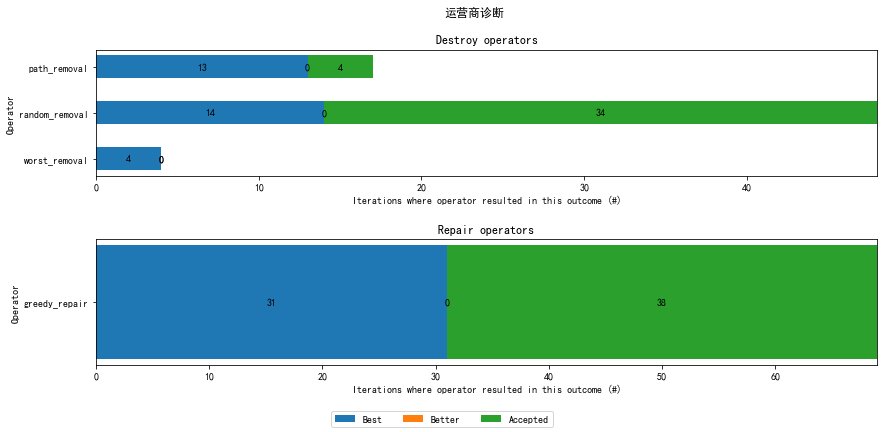

In [36]:
figure = plt.figure("operator_counts", figsize=(14, 6))
figure.subplots_adjust(bottom=0.15, hspace=.5)
result.plot_operator_counts(figure=figure, title="运营商诊断", legend=["Best", "Better", "Accepted"])

几个结论
在销毁操作符中，random_remove和path_remove的执行情况相似:虽然random_remove在更容易被接受的解状态下得到的结果是一致的，但二者找到全局最佳状态的速度是相同的。注意，worst_remove实际上不会导致许多更好或等效的状态，这表明它不如其他两个销毁操作符。
greedy_repair修复启发式导致许多解状态低于当前的最佳状态，因此被ALNS算法拒绝。这是不幸的，并建议一个更好的修复启发式应该被发现。理想情况下，这样的启发式会更好地利用问题结构。

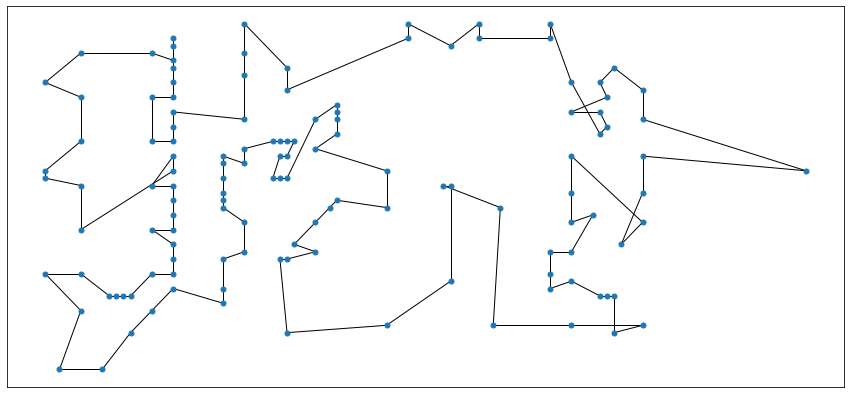

In [37]:
draw_graph(solution.to_graph()) 

几个结论

后期处理

不难看出，上面的解决方案可以很容易地加以改进:在靠近中心和各个角落的小的子路中，都有许多效率低下的地方。我们将通过一次遍历所有节点来部分解决这个问题，最优地从每个节点开始选择长度为k的子路径。由于这样的过程需要计算，我们选择k = 8。

In [41]:
k = 8
def fix_bounds(permutation, start_node, end_node):

#修复开始节点和结束节点的给定排列，这样它连接到解决方案的剩余部分。

    return (start_node,) + permutation + (end_node,)

In [42]:
def optimal_subpath(nodes, start_node, end_node):

#计算给定节点的最小代价子路径，其中子路径固定在start_node和end_node上。

    def cost(subpath):
        path = fix_bounds(subpath, start_node, end_node)
        
        return sum(distances.euclidean(path[idx][1], path[idx + 1][1])
                   for idx in range(len(path) - 1))

    subpath = min(itertools.permutations(nodes, k), key=cost)

    return fix_bounds(subpath, start_node, end_node)

In [43]:
def post_process(state):
    """
    对于处于传入状态的每个节点，此后处理步骤计算由下k个节点组成的最优子路径。
    这导致运行时复杂度约为O(n * k!)，其中n为节点的数量。
    """
    state = state.copy()

    for start_node in state.nodes:
        nodes = []
        node = start_node

        # 确定组成子路径开始的下一个k个节点
        # 在这个开始节点
        for _ in range(k):
            node = state.edges[node]
            nodes.append(node)
        
        end_node = state.edges[node]

        optimal = optimal_subpath(nodes, start_node, end_node)
        
        # 用最优子路径替换现有路径。
        for first, second in zip(optimal, optimal[1:]):
            state.edges[first] = second

    return state

In [44]:
new_solution = post_process(solution)
new_objective = new_solution.objective()

print("新的启发式目标是{0}.".format(new_objective))
print('This is {0:.1f}% worse than the optimal solution, which is {1}.'
      .format(100 * (new_objective - optimal) / optimal, optimal))

新的启发式目标是588.
This is 4.3% worse than the optimal solution, which is 564.


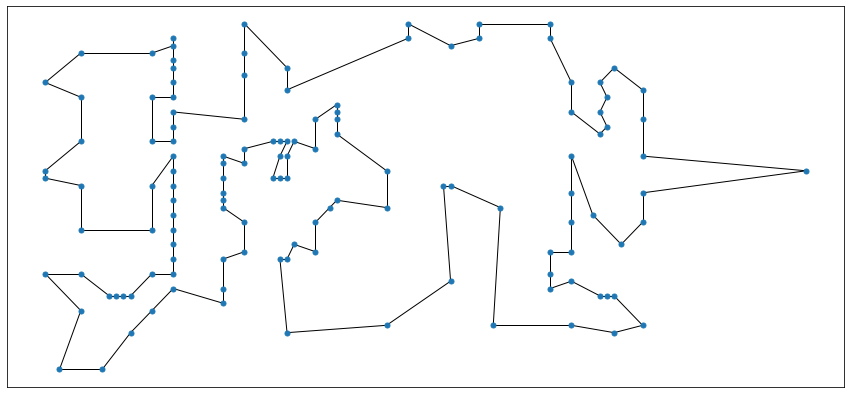

In [45]:
draw_graph(new_solution.to_graph())

结论

在上面的代码中，我们使用ALNS元启发式框架为TSP实现了一个非常简单的启发式。我们没有对ALNS实现中可用的各种超参数做太多修改，但即使对于这些相对基本的启发式方法和工作流，我们也发现了一个非常好的结果——仅比最优tour差2.1%。
本笔记本展示了如何使用ALNS库从简单的、局部贪婪的操作符构建强大、高效的启发式管道。